# Particle Filter 
This file contains the explanation of the Particle Filter algorithm. The main steps are as follows:
1. Initialization --> Creat_uniform_particles function
2. Prediction --> Predict function
3. Update
4. Resampling




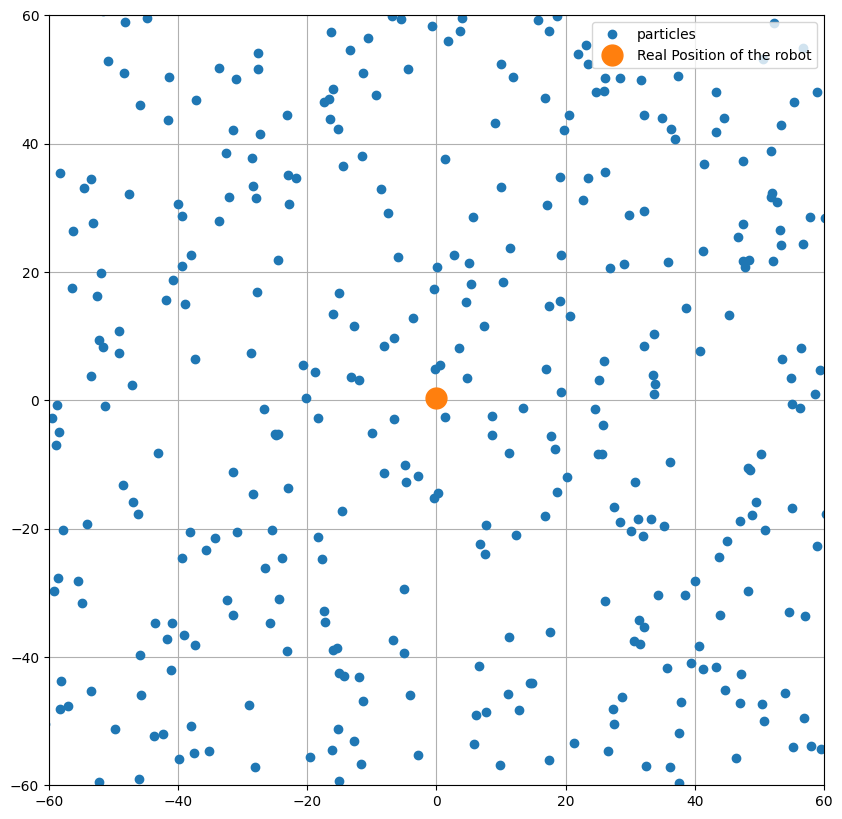

[-2.580127105850849, 1.2777359152965249, 3.1415926535897944]
[[2.81250000e-01 1.72215956e-17 3.14159265e+00]]
-------------------


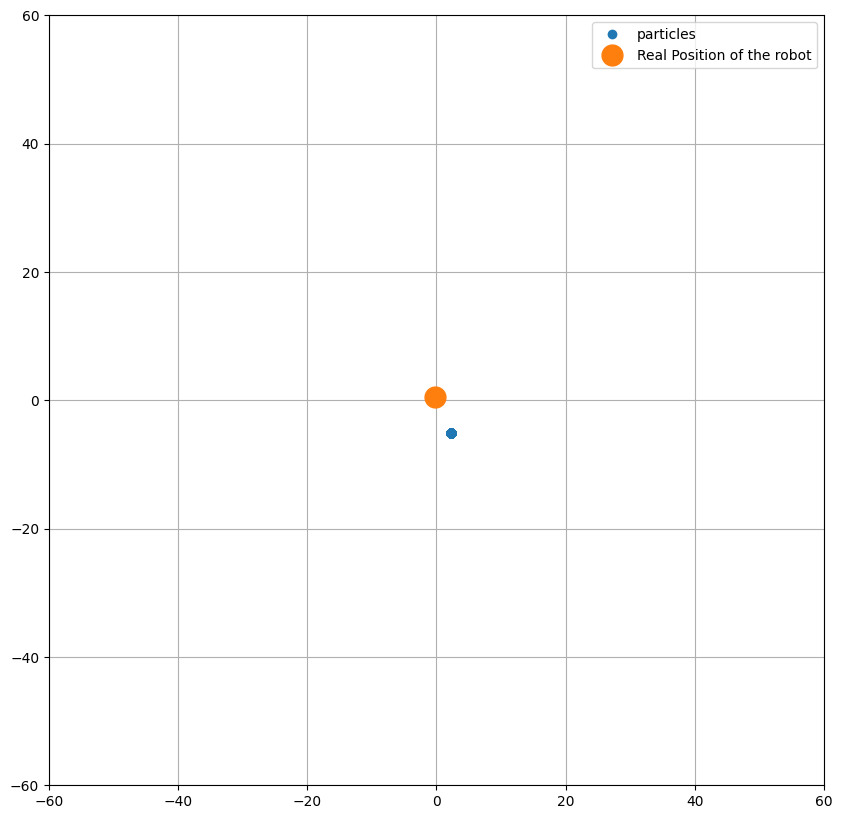

[-5.160254211701698, 2.2742218305930497, 6.283185307179589]
[[ 0.5625     -0.28125     6.28318531]]
-------------------


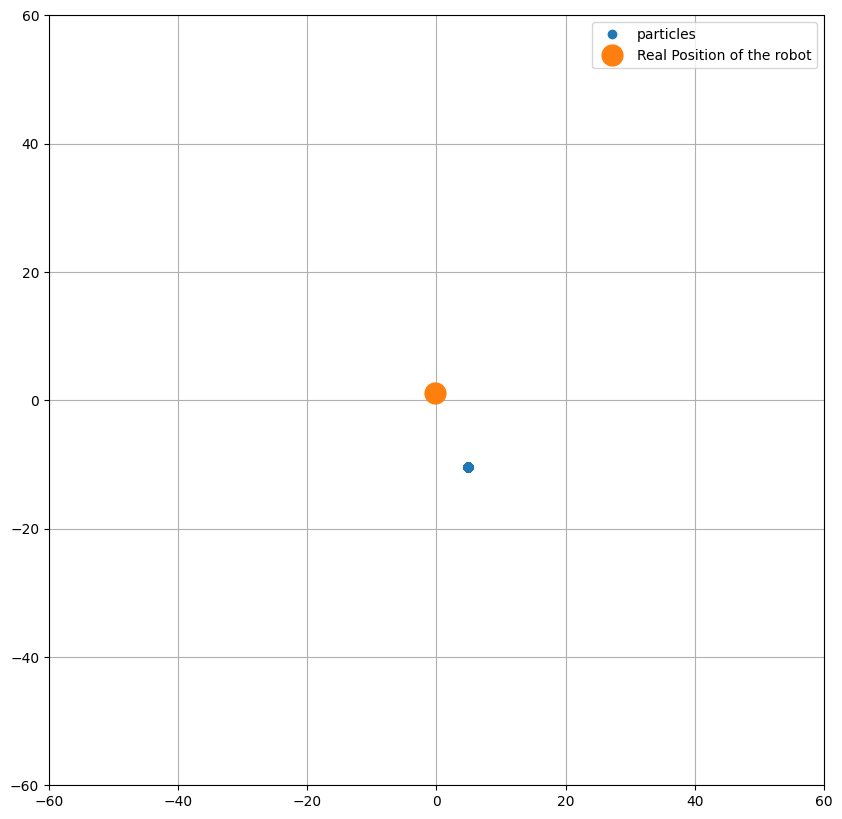

[-10.320508423403396, 4.829693661186099, 6.283185307179589]
[[ 1.125      -0.28125     6.28318531]]
-------------------


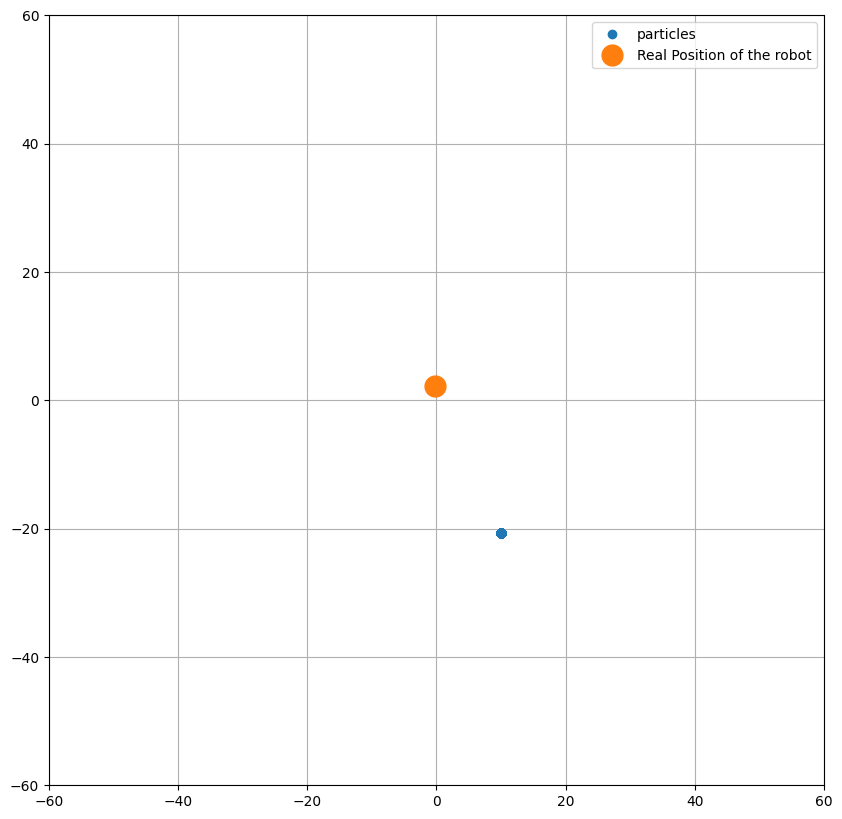

[-20.641016846806792, 9.940637322372199, 6.283185307179589]
[[ 2.25       -0.28125     6.28318531]]
-------------------


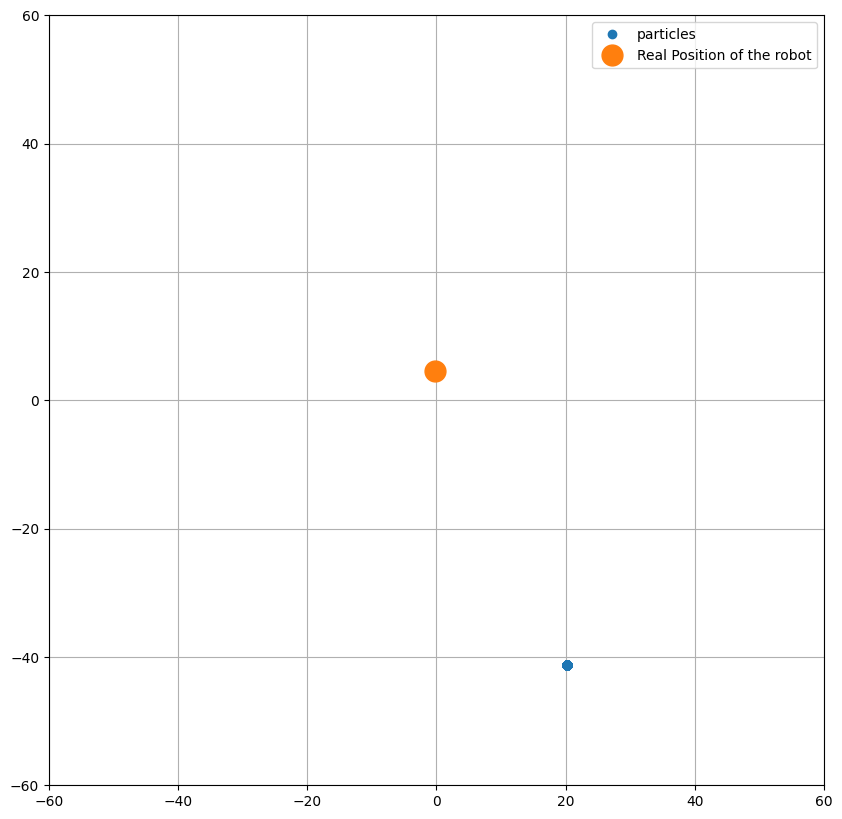

[-41.282033693613585, 20.162524644744398, 6.283185307179589]
[[ 4.5        -0.28125     6.28318531]]
-------------------


In [8]:
# importing standard libraries 
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import uniform , random
from scipy.stats import multivariate_normal
from Robot import Diif_Robot

def create_uniform_particles(x_range,y_range,hdg_range,N):
    """"
    Create particles uniformly distributed in a given range.
    x_range: tuple (min,max) - map width limits
    y_range: tuple (min,max) y - map height limits 
    hdg_range: tuple (min,max) heading range
    N: int
    """
    particles = np.empty((N,3))
    particles[:,0] = uniform(y_range[0],y_range[1],size=N)
    particles[:,1] = uniform(x_range[0],x_range[1],size=N)
    particles[:,2] = uniform(hdg_range[0],hdg_range[1],size=N)
    particles[:,2] %= 2 * np.pi

    return particles

def predict(particles, u, motion_dist, dt):
    """"
    Predict the position of the particles after a movement command.
    particles: 2D numpy array
    u: tuple (v,w) - velocity and angular velocity
    motion_dist: tuple (alpha1,alpha2,alpha3,alpha4) - motion noise parameters
    dt: float - time step
    """
    for i in range(len(particles)):
        Motion = Diif_Robot(0.75,0.3/2,particles[i,1],particles[i,0],particles[i,2])
        particles[i,:] += Motion.motion_model(u,dt) + motion_dist
    return particles

def update(particles, y, w , Q):
    """
    Update the weights of the particles using a measurement.
    particles: 2D numpy array
    y: Robot location (?)
    w: numpy array - weights
    Q: 2D numpy array - measurement noise
    """
    for i in range(len(particles)):
        w[i] = multivariate_normal.pdf(y,mean=particles[i,0:2], cov=Q)
    w += 1.e-300
    w /= sum(w)

    return w

def simple_resample(particles, weights):
    """
    Resample particles with a simple method.
    particles: 2D numpy array
    weights: numpy array
    """
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))
    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)

    return particles



mean_distribution_meas = np.array([0,0])
Q = np.array([[0.01,0],[0,0.01]])
delta_meas = np.random.multivariate_normal(mean_distribution_meas , Q)


#The following function is used to plot the actual position of the robot and particles on the map
def creat_plot(particles,state_real,x_lim,y_lim):
  f = plt.figure(figsize=(5,5))
  # define figure size
  ax = f.add_subplot(1, 1, 1)
  f.set_figwidth(10)
  f.set_figheight(10)
  plt.plot(particles[:,1],particles[:,0],'o',label='particles')
  plt.plot(state_real[1],state_real[0],'.',label='Real Position of the robot', markersize=30)
  plt.xlim(x_lim[0]*1.2,x_lim[1]*1.2)
  plt.ylim(y_lim[0]*1.2,y_lim[1]*1.2)
  plt.legend(loc='upper right')
  plt.grid()
  plt.show()


No_Particles = 1000
x_range = (-50,50)
y_range = (-50,50)
hdg_range = (0, np.pi*2)
robot_state = np.array([[0.0,0.0,np.pi/2]]) # this is the initial real state of the robot
particles = create_uniform_particles(x_range, y_range, hdg_range, No_Particles)

## Define robot specification 
u = np.array([10,0])
## Defining epsilon == motion distribution
mean_distribution = np.array([0,0,0])
var_distribution = 0
cov_distribution = 0
R = np.array([[var_distribution,cov_distribution,cov_distribution],[cov_distribution,var_distribution,cov_distribution],[cov_distribution,cov_distribution,var_distribution]])
motion_dist = np.random.multivariate_normal(mean_distribution , R)

dt = 0.1
delta_meas = np.array([0.001,0.0001])
w = np.ones(No_Particles)/No_Particles


for i in range(5):
    particles = predict(particles,u,motion_dist,dt)
    robot_state = predict(robot_state,u,motion_dist,dt)
    creat_plot(particles,robot_state[0],x_range,y_range)
    y = robot_state[0,0:2] + delta_meas
    w = update(particles,y,w,Q)
    particles = simple_resample(particles,w)
    particles[:,2] = robot_state[0,2]
    # creat_plot(particles,robot_state[0],x_range,y_range)
    print([np.mean(particles[:,0]),np.mean(particles[:,1]),np.mean(particles[:,2])])
    print(robot_state)
    print('-------------------')

